This notebook is the part of the coursework from the Deep Learning School. The aim of this task was to train the models for face generation

# Part1. Vanilla Autoencoder (10 баллов)

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

                       person  ...                                         photo_path
0      Sergio Vieira De Mello  ...  lfw-deepfunneled/Sergio_Vieira_De_Mello/Sergio...
1      Sergio Vieira De Mello  ...  lfw-deepfunneled/Sergio_Vieira_De_Mello/Sergio...
2      Sergio Vieira De Mello  ...  lfw-deepfunneled/Sergio_Vieira_De_Mello/Sergio...
3      Sergio Vieira De Mello  ...  lfw-deepfunneled/Sergio_Vieira_De_Mello/Sergio...
4      Sergio Vieira De Mello  ...  lfw-deepfunneled/Sergio_Vieira_De_Mello/Sergio...
...                       ...  ...                                                ...
13228             Mike Helton  ...  lfw-deepfunneled/Mike_Helton/Mike_Helton_0002.jpg
13229             Mike Helton  ...  lfw-deepfunneled/Mike_Helton/Mike_Helton_0001.jpg
13230             Paul Pierce  ...  lfw-deepfunneled/Paul_Pierce/Paul_Pierce_0002.jpg
13231             Paul Pierce  ...  lfw-deepfunneled/Paul_Pierce/Paul_Pierce_0001.jpg
13232             Takuma Sato  ...  lfw-deepfunneled/T

Train-test split:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

Image example:

In [ ]:
examples = next(iter(train_loader))

(64, 64, 3)


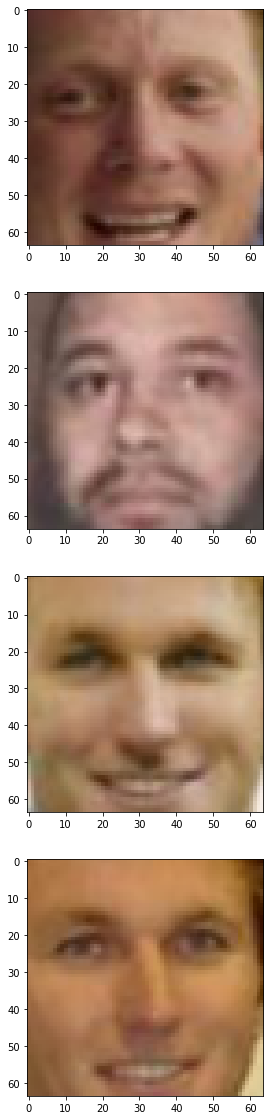

In [ ]:
plt.figure(figsize=(8, 20))
for i in range(1,5):
  plt.subplot(4, 1, i)
  plt.imshow(examples[i].numpy())
print(examples[i].numpy().shape)


## 1.2. Model's architecture (1.5 sc)


<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



In [1]:
dim_code = 16  # latent vector size

In [ ]:
features = 16
# define a simple linear VAE
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=12288, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features)

        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=12288)
        )
    def forward(self, x):
          latent_code = self.encoder(self.flatten(x))
          reconstruction = self.decoder(latent_code).view(-1, 64, 64, 3)
          return reconstruction, latent_code

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:
loss_fn = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Training (2 sc)

In [ ]:
from tqdm.notebook import tqdm

  0%|          | 0/30 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


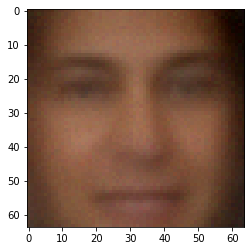

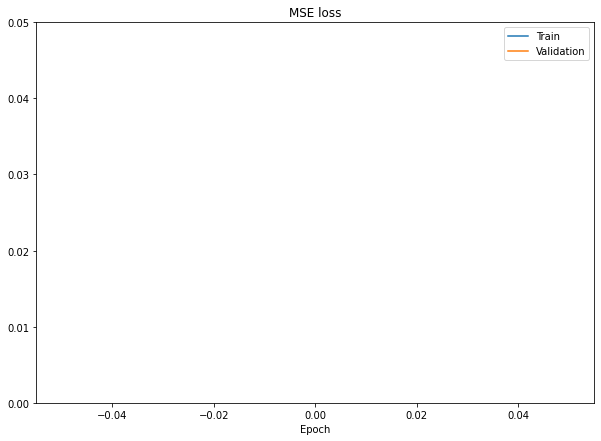

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


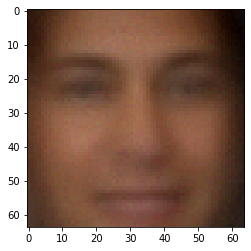

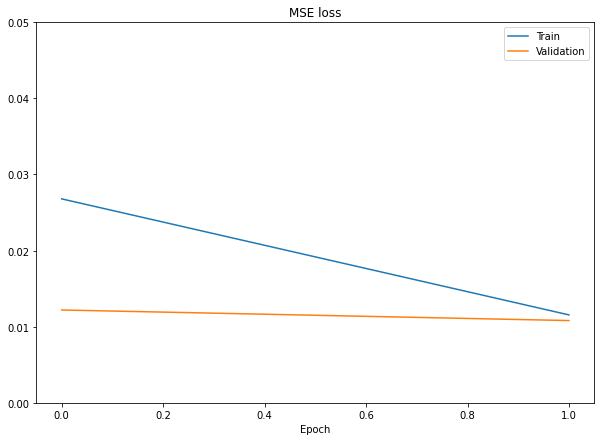

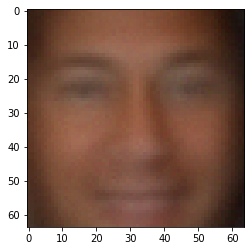

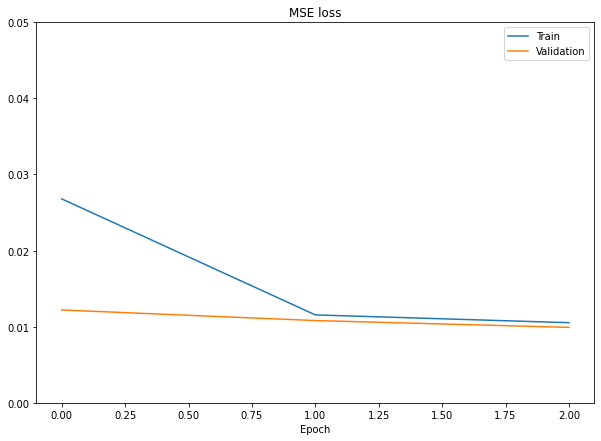

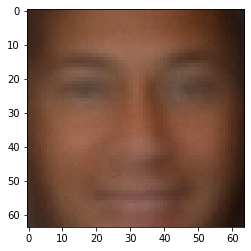

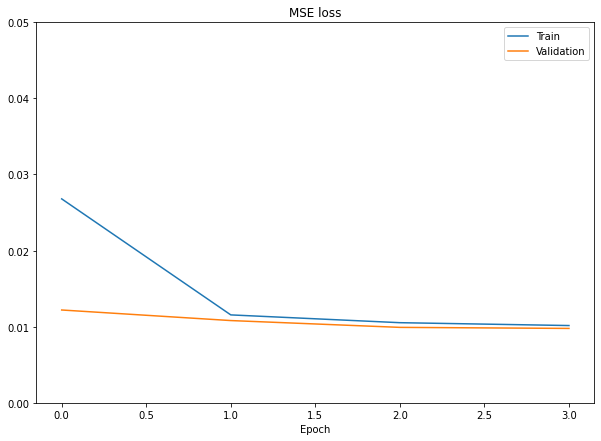

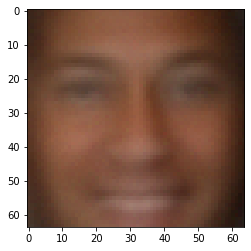

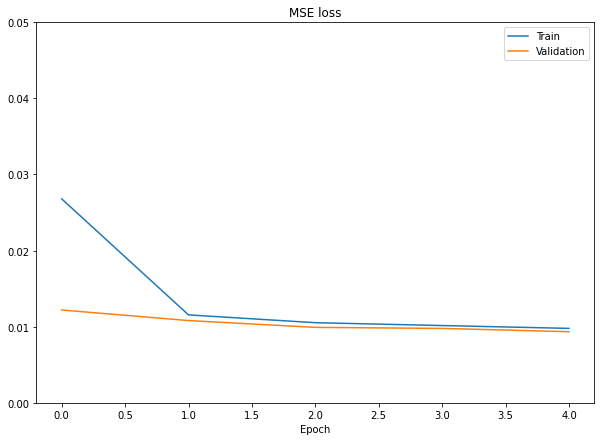

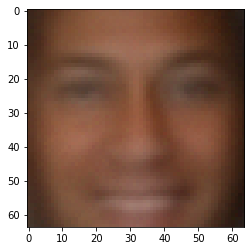

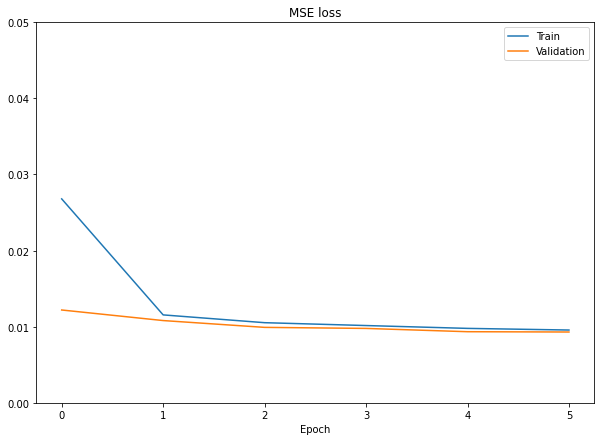

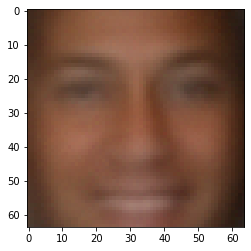

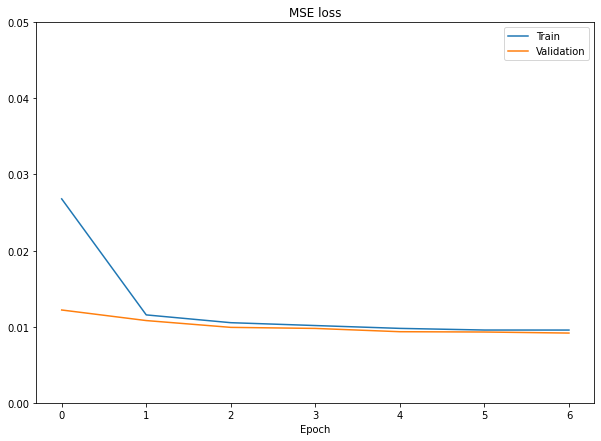

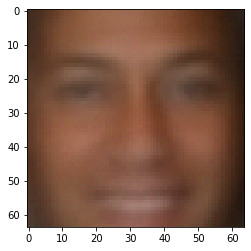

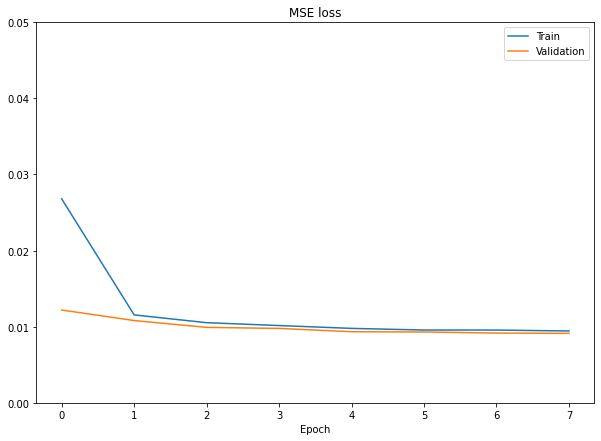

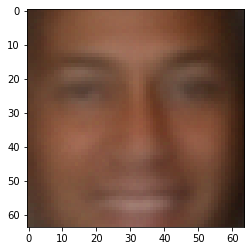

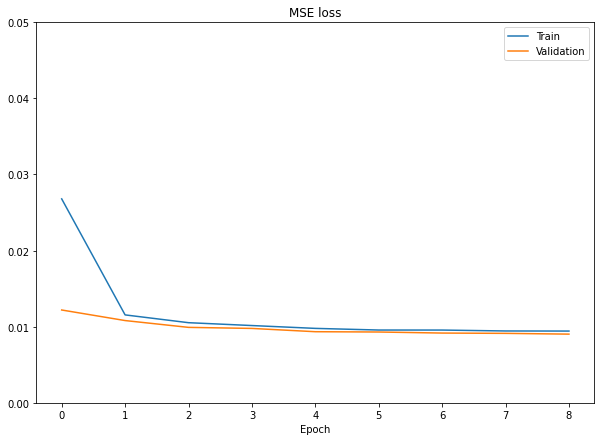

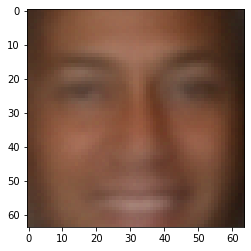

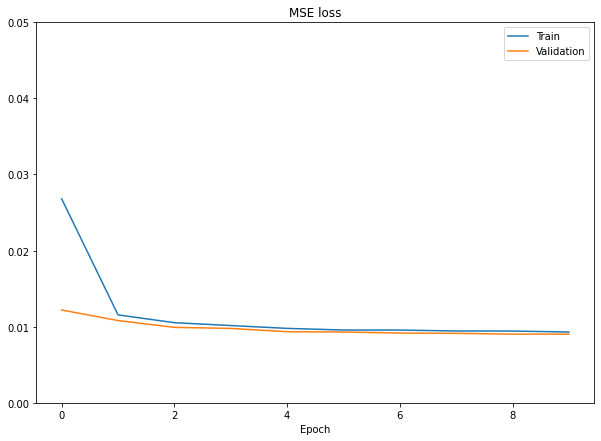

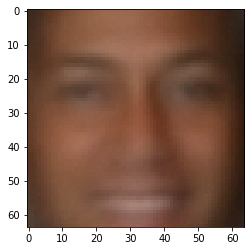

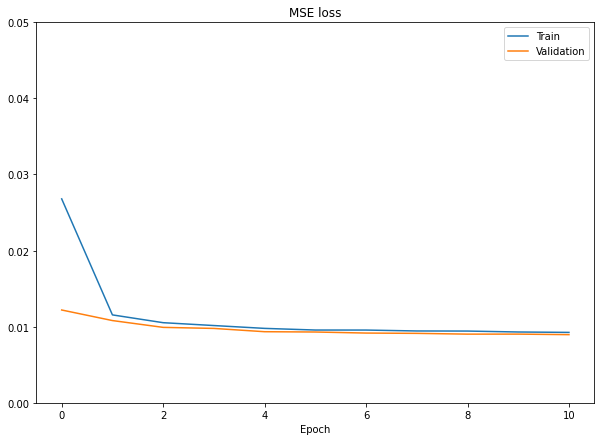

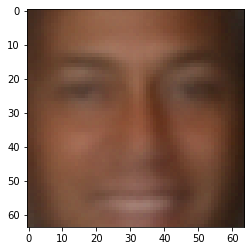

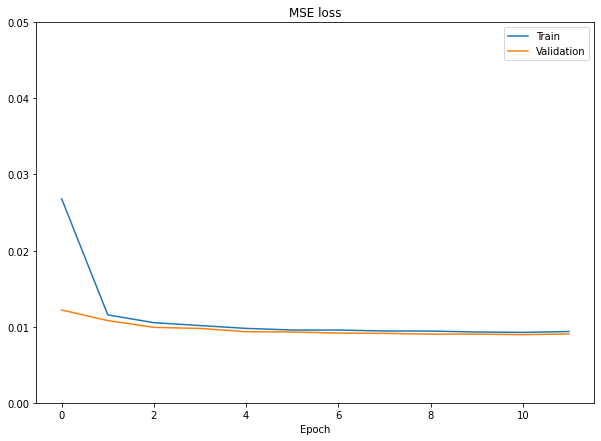

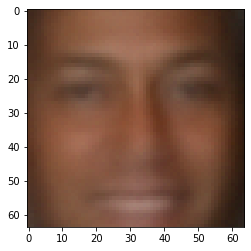

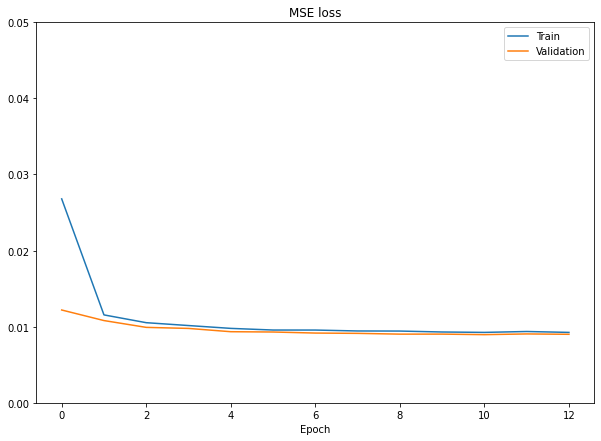

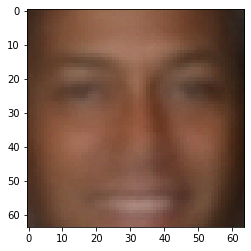

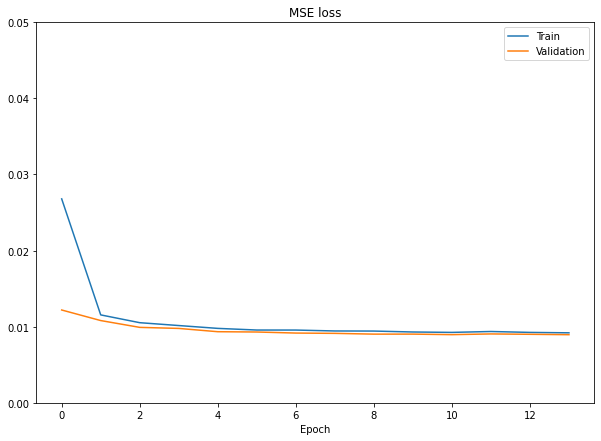

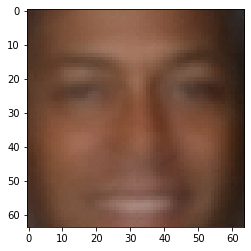

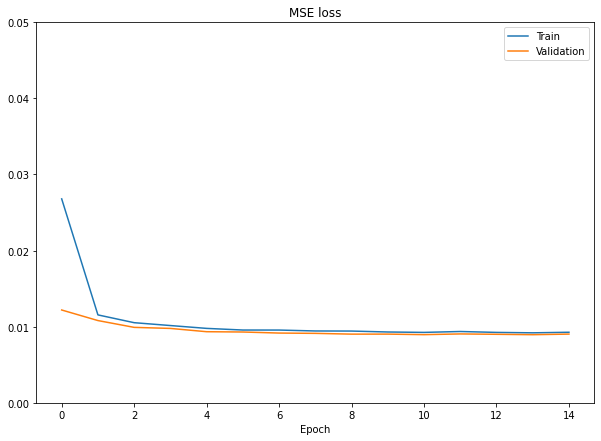

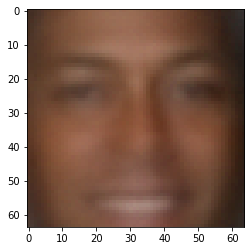

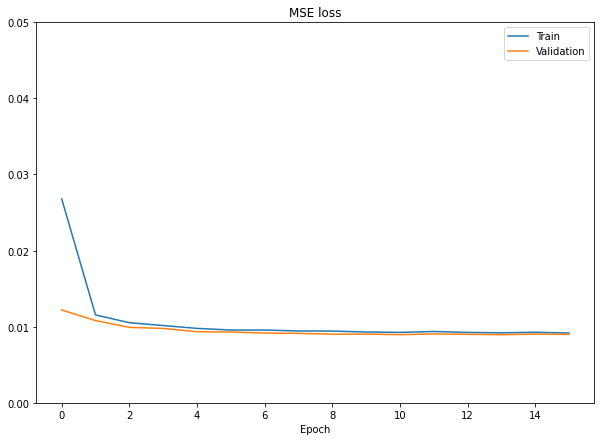

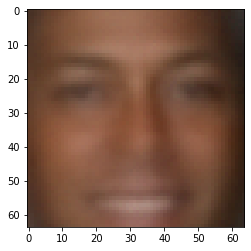

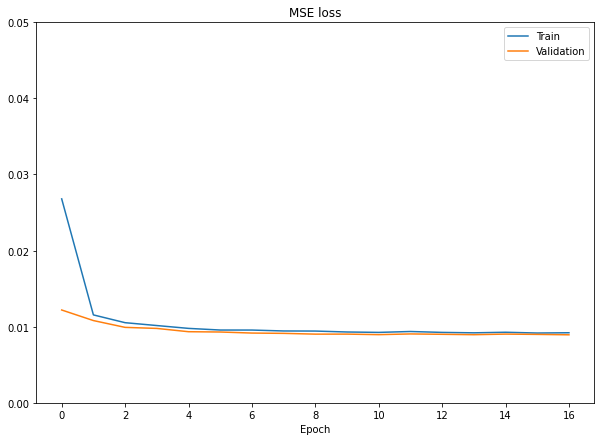

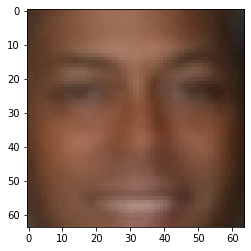

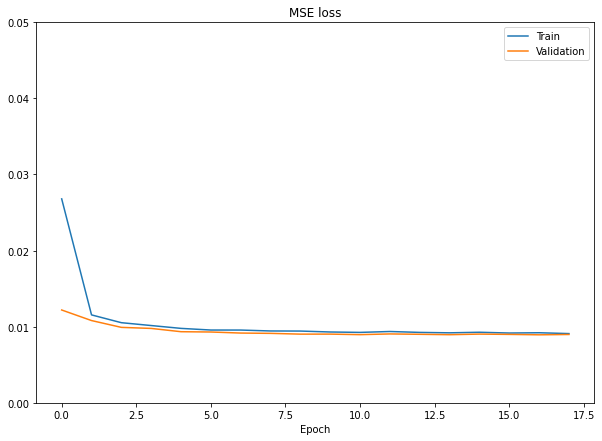

KeyboardInterrupt: ignored

In [ ]:
n_epochs = 30
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed = autoencoder(X_batch.to(device).float())[0]
        loss = loss_fn(reconstructed, X_batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed = autoencoder(X_batch.to(device).float())[0]
          loss = loss_fn(reconstructed, X_batch.to(device).float())
          val_losses_per_epoch.append(loss.item())

    plt.imshow(reconstructed[0].numpy())
    val_losses.append(np.mean(val_losses_per_epoch))
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
    plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

    plt.ylim(0, 0.05)
    plt.xlabel('Epoch')
    plt.title('MSE loss')
    plt.legend()
    plt.show()

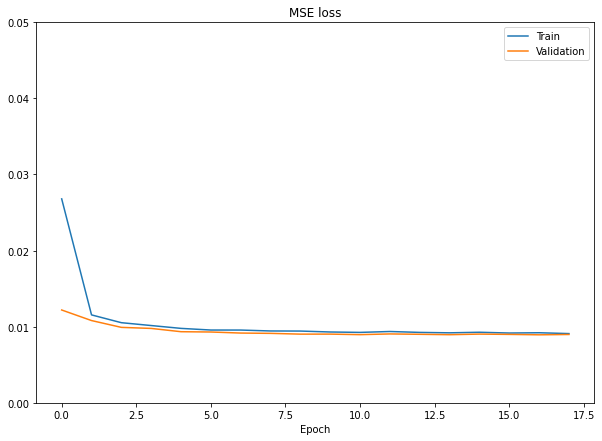

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')
plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

#### Model in action

In [ ]:

autoencoder.eval()
with torch.no_grad():
    for batch in val_loader:
      reconstruction = autoencoder(batch.to(device).float())[0]
      
      result = reconstruction.cpu().detach().numpy()
      ground_truth = batch.numpy()
      break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


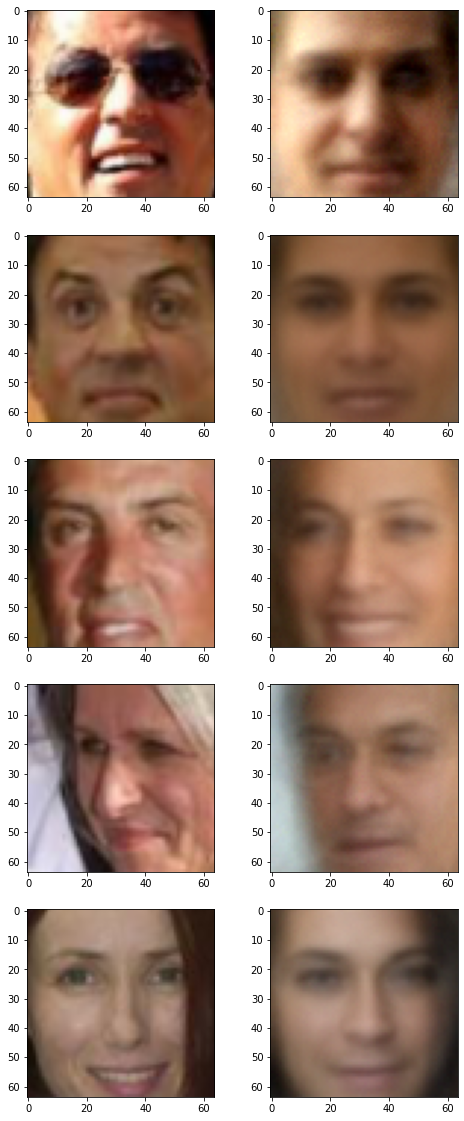

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 points)

Now instead of using images we put random vector to autoencoder

In [ ]:

z = np.random.randn(25,  16)
#z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
#output = autoencoder(torch.FloatTensor(z).to(device))[1]

generated = autoencoder.decoder(torch.FloatTensor(z).to(device))

generated = torch.sigmoid(generated)
generated = generated.view(-1, 64, 64, 3)

      

In [ ]:
generated.shape

torch.Size([25, 64, 64, 3])

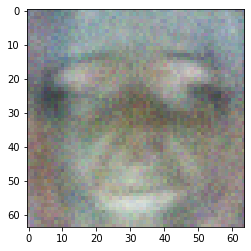

In [ ]:
plt.imshow(generated[0].detach().numpy() )

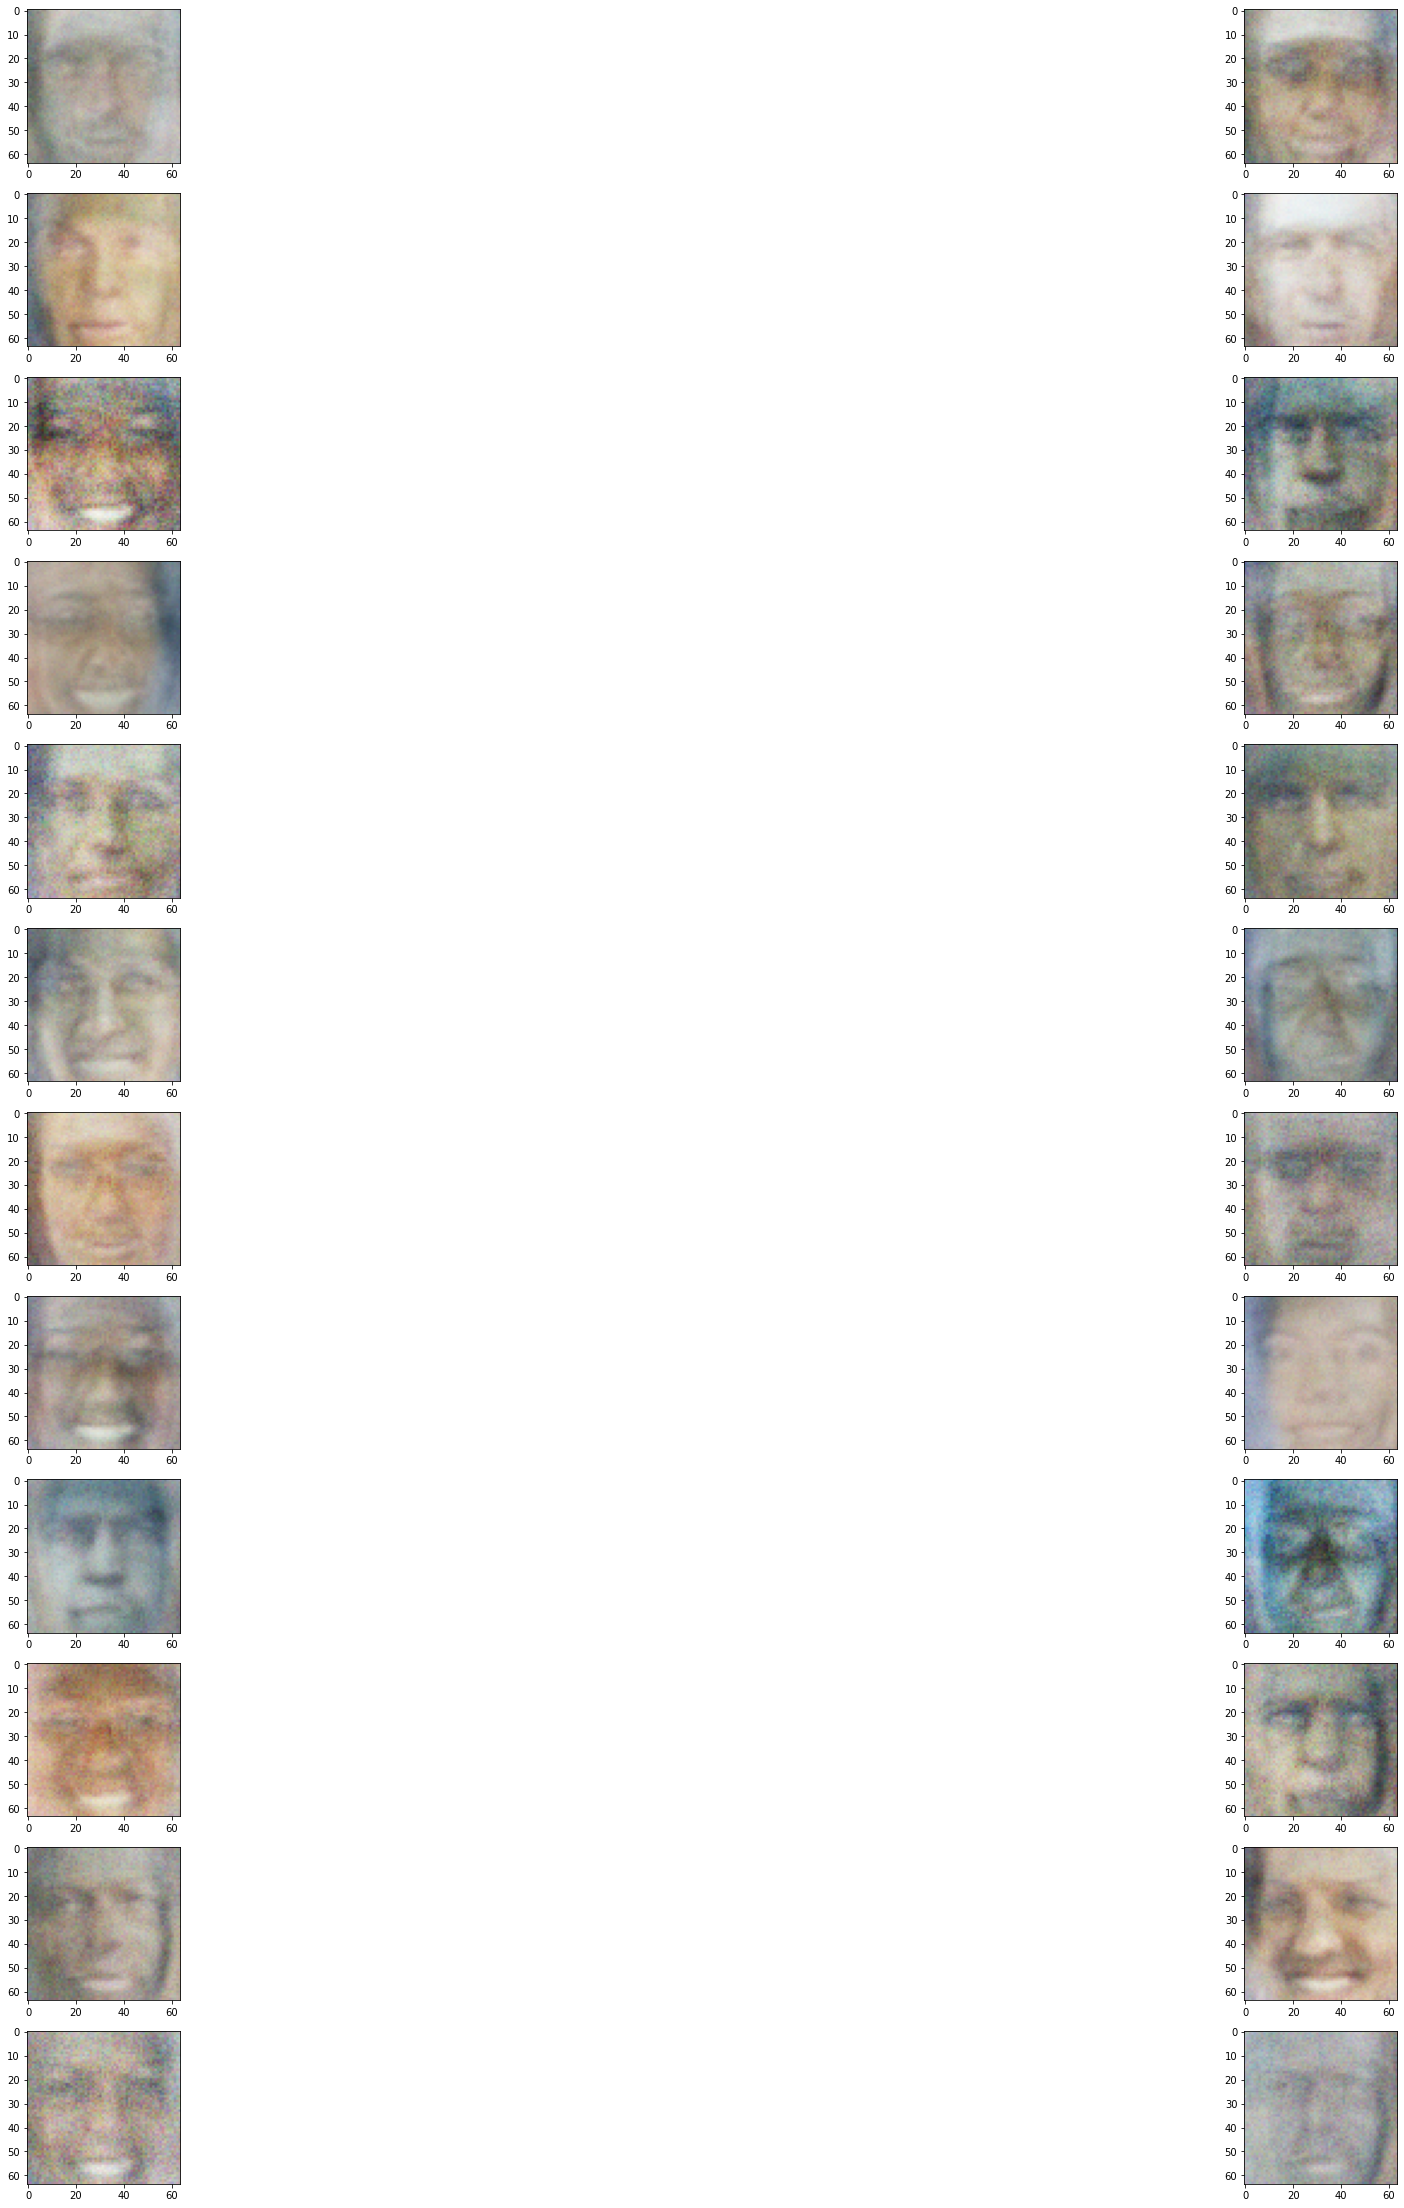

In [ ]:
plt.figure(figsize=(40, 40))
for i in range(1,25):
  plt.subplot(24 // 2, 2, i)
 
  plt.imshow(generated[i].detach().numpy())

plt.show()

In [ ]:
torch.save(autoencoder.state_dict(), 'Model.pth')

In [ ]:
the_model = Autoencoder()
the_model.load_state_dict(torch.load('\content\lfw-deepfunneled'))

<All keys matched successfully>

## Time to make fun! (4 points)

Let's learn how to make people smile =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

The plan is this:

1. To do this, you need to find several (~15) people with smiles and the same number of people without smiles from a sample of images.

To find people with smiles you can use the dataset description file, downloaded together with the dataset. It contains picture names and attributes (smiles, glasses...).

2. Calculate a latent vector for all smiling people (run them through the encoder) and the same for all sad people

3. Calculate the actual vector of smiling - calculate the difference between the average latent vector of smiling people and the average latent vector of sad people

Now let's add the vector obtained in item 3 to the latent vector of a sad person and run this vector through decoder. We will get the same person, but not a sad one anymore!

The 15 most smiling

In [ ]:
attrs.sort_values(by=['Smiling'])['Smiling'].tail(15)


682      2.63969
6166      2.6517
459      2.65912
9004     2.66416
1955     2.66992
2031     2.67085
1359     2.67718
11797    2.68316
6139     2.71663
4681     2.71721
1045     2.73704
5624     2.74382
13034    2.78115
1816     2.79183
8643     2.83999
Name: Smiling, dtype: object

15 saddest

In [ ]:
attrs.sort_values(by=['Smiling']).head(15)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
11571,2.13624,-0.882146,-1.18633,-0.70506,-2.04264,-0.249438,-0.519952,0.347819,-1.78174,0.662374,-1.52815,0.510962,-1.62564,2.15575,-1.47569,-1.03609,0.249022,-2.68659,2.77643,-0.244085,-0.532109,-0.948436,-1.04494,1.61582,0.387428,0.880014,-0.760429,0.379872,-0.544663,1.43572,0.652962,-1.20607,-0.340497,0.0847492,1.60039,-1.97235,0.167625,1.19816,0.192164,0.450381,1.1016,-1.05092,-0.118639,-0.550332,1.16606,-0.425347,0.224402,0.0171938,-0.368915,-1.04276,0.185768,-0.198535,-0.592715,0.78169,-0.218066,-0.542437,-0.814121,-0.187443,-1.02359,0.399453,-1.33492,-2.79428,-0.804176,-1.96533,1.99681,-1.30778,-2.07094,-3.83154,-1.79607,1.69902,-1.39908,-0.412097,-1.84327
1234,0.954913,-0.983356,2.067,-2.49582,-1.52877,-0.510492,-1.02894,-0.17107,-1.04501,-1.00008,-0.260434,0.512037,-1.62603,1.15367,-0.309216,-2.19766,-0.350291,-2.66448,2.68302,0.612659,-1.48806,-1.30216,-0.448976,1.45569,-0.280929,0.573047,-0.352814,-0.286481,0.0846007,-0.811595,-0.415044,0.110104,-0.347048,-0.40867,-1.31037,0.272894,-0.693458,2.14676,-1.65071,1.69862,-0.120361,0.286254,-0.28992,-0.718144,1.06015,0.134266,-0.0711387,0.128932,0.156428,-0.211038,0.18746,-0.586896,-0.2673,4.27009,0.80884,-0.486308,-0.864898,-1.94131,-0.8908,-0.459661,-1.01371,0.701034,-1.60782,-0.337012,0.729144,-1.76426,-1.49386,0.922482,-1.47265,-1.25914,-0.776729,-0.104821,-1.22919
7506,1.43308,-1.0669,1.31518,-3.14007,-2.3704,-0.899272,-0.205467,-0.578259,-0.725278,-1.77205,-0.109994,-1.59503,-1.45965,1.0285,-1.57053,-1.2133,-1.2884,-2.64355,2.72302,-1.39483,-0.90757,-1.37887,-1.04634,1.39242,-0.425786,0.482783,-0.185388,-0.467249,-0.354531,-0.343064,-0.0496639,-0.232342,-0.224391,0.121168,0.0150441,-1.49369,-0.315364,2.18387,-1.21939,1.05991,-0.708808,0.920538,-1.52141,-0.901137,1.30113,0.741208,-0.489363,0.220032,-0.588099,-0.419803,0.386938,-0.420313,-0.717756,1.52499,0.69746,1.04633,-0.493567,-1.3413,-1.37292,-0.705249,-0.830898,-1.7449,-1.20992,0.144389,-0.580812,-1.61756,-0.866478,-3.56361,-1.44259,-0.961867,-0.694462,-0.110776,-0.868778
5458,-0.188162,-0.647783,0.715927,-2.76761,-2.21039,-0.379383,-0.167709,-0.813777,-1.36702,-1.80845,0.505613,-0.611531,-1.47177,2.08903,-1.81059,-1.53889,-1.3664,-2.63975,2.71643,1.09554,-0.862419,-0.943296,-1.70693,1.19373,0.43543,0.375474,-0.013277,0.0444094,-1.31191,-0.477799,-0.347753,-0.155622,-0.304943,-0.787855,-0.695325,-0.745607,1.34598,1.47785,-0.651079,0.558446,0.181205,-0.503759,-0.0874418,-1.10772,1.5582,1.08047,-0.860124,0.252413,0.0638529,-1.06328,-0.108704,-0.785428,-0.0041451,2.68409,0.4467,-0.795015,-0.441005,-1.66714,-1.15455,-0.139051,-1.09452,0.631594,-1.04457,0.842378,-0.674481,-1.10116,-1.05383,-1.65771,-1.63174,0.219495,-1.00742,0.464435,-0.972584
7065,1.65926,-0.886879,0.79353,-1.15237,-1.30286,-0.241565,0.380882,-0.723661,-0.7521,-0.99002,-0.499866,-1.09243,-0.981157,0.744052,-1.73844,-0.558358,-0.77448,-2.63077,2.58482,-0.739837,-0.695199,-0.142387,-1.21946,1.36132,0.476235,0.145654,0.862377,-1.14007,-0.484857,0.0633071,-0.125703,-1.94324,-0.471364,0.516583,-0.216452,-2.51983,0.377165,1.19426,-0.680197,0.609426,0.386815,0.364327,-0.532347,-0.962451,1.22833,0.65179

In [ ]:
list_smiling = list(attrs.sort_values(by=['Smiling']).tail(15).index)
list_sad = list(attrs.sort_values(by=['Smiling']).head(15).index)

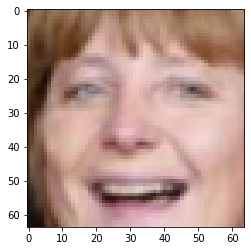

In [ ]:

plt.imshow(data[648])


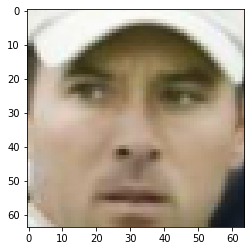

In [ ]:
plt.imshow(data[9114])

In [ ]:
torch.from_numpy(data[9114]).shape

torch.Size([64, 64, 3])

In [ ]:
smiling_people = []
for i in list_smiling:
  pearson = autoencoder.encoder(torch.from_numpy(data[i]).view(-1, 12288).float())
  smiling_people.append(pearson)

In [ ]:

smiling_people_tensor = torch.cat(smiling_people,0)


In [ ]:
smiling_people_tensor.size()


torch.Size([15, 16])

In [ ]:
smiling_vector = torch.mean(smiling_people_tensor,0)

In [ ]:
smiling_vector.size()

torch.Size([16])

In [ ]:
sad_people = []
for i in list_sad:
  pearson = autoencoder.encoder(torch.from_numpy(data[i]).view(-1, 12288).float())
  sad_people.append(pearson)

sad_people_tensor = torch.cat(sad_people,0)
sad_vector = torch.mean(sad_people_tensor,0)

In [ ]:
smile_vector = smiling_vector - sad_vector

In [ ]:
smile_vector.size()

torch.Size([16])

In [ ]:
smile_vector = smile_vector.view(1,16)

In [ ]:
sad_but_smile = sad_people[0] + smile_vector

In [ ]:
sad_but_smile_tensor = autoencoder.decoder(sad_but_smile.to(device))

#sad_but_smile_tensor = torch.sigmoid(sad_but_smile_tensor)
generated_ss = sad_but_smile_tensor.view(64, 64, 3)

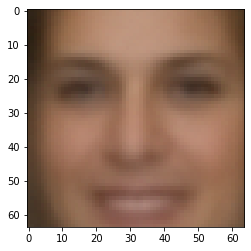

In [ ]:
plt.imshow(generated_ss.detach().numpy())

The same, but not smilimg

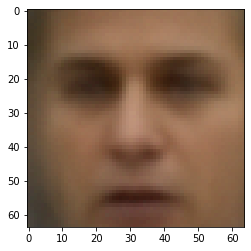

In [ ]:
sad_but_smile_tensor = autoencoder.decoder(sad_people[0].to(device))

#sad_but_smile_tensor = torch.sigmoid(sad_but_smile_tensor)
generated_ss = sad_but_smile_tensor.view(64, 64, 3)
plt.imshow(generated_ss.detach().numpy())